Kumar Raunak GAP Implementation

Environment


In [ ]:
import numpy as np
import gym
from gym import spaces

class ServicePlacementEnv(gym.Env):
    def __init__(self, utilities, vm_requirements, capacities):
        super(ServicePlacementEnv, self).__init__()
        self.utilities = np.array(utilities)
        self.vm_requirements = np.array(vm_requirements)
        self.capacities = np.array(capacities)

        self.num_servers, self.num_users = self.utilities.shape

        # Action space: one action per server
        self.action_space = spaces.Discrete(self.num_servers)

        # Observation space: variable servers, 2 features per server
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.num_servers, 2), dtype=np.float32)

        self.reset()

    def reset(self):
        self.remaining_capacities = self.capacities.copy()
        self.current_user = 0
        self.server_assignments = np.zeros((self.num_users, self.num_servers))
        return self._get_state()

    def _get_state(self):
        if self.current_user >= self.num_users:
            current_requirements = np.zeros(self.num_servers)
        else:
            current_requirements = [self.vm_requirements[s][self.current_user] for s in range(self.num_servers)]

        # Stack capacities and current requirements (shape: [num_servers, 2])
        state = np.stack([self.remaining_capacities, current_requirements], axis=1).astype(np.float32)
        return state

    def get_valid_actions(self):
        return [s for s in range(self.num_servers)
                if self.remaining_capacities[s] >= self.vm_requirements[s][self.current_user]]

    def step(self, action):
        if self.current_user >= self.num_users:
            return self._get_state(), 0, True, {}

        valid_actions = self.get_valid_actions()
        reward = 0

        if not valid_actions:
            self.current_user += 1
            done = self.current_user >= self.num_users
            return self._get_state(), -5, done, {}

        if action in valid_actions:
            reward = self.utilities[action][self.current_user]
            self.remaining_capacities[action] -= self.vm_requirements[action][self.current_user]
            self.server_assignments[self.current_user, action] = 1
        else:
            reward = -10

        self.current_user += 1
        done = self.current_user >= self.num_users
        return self._get_state(), reward, done, {}

    def get_assignments(self):
        return self.server_assignments

Agent


In [ ]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

class DQNAgent:
    def __init__(self, feature_dim, max_servers):
        self.feature_dim = feature_dim        # Features per server (2: capacity, demand)
        self.max_servers = max_servers        # Maximum servers across all problems
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=(None, self.feature_dim))  # Variable server count, fixed feature size
        x = layers.Masking(mask_value=0.0)(inputs)
        x = layers.LSTM(64)(x)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(self.max_servers, activation='linear')(x)

        model = models.Model(inputs, outputs)
        model.compile(loss='mse', optimizer=optimizers.Adam(0.001))
        return model

    def act(self, state, valid_actions):
        # Pad state to maximum server size for consistency
        padded_state = self._pad_state(state)
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)
        q_values = self.model.predict(np.array([padded_state]), verbose=0)[0]
        masked_q_values = [q_values[a] if a in valid_actions else -np.inf for a in range(state.shape[0])]
        return np.argmax(masked_q_values)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))

        for state, action, reward, next_state, done in minibatch:
            padded_state = self._pad_state(state)
            padded_next_state = self._pad_state(next_state)

            target = reward
            if not done:
                next_q_values = self.model.predict(np.array([padded_next_state]), verbose=0)[0]
                target += self.gamma * np.max(next_q_values)

            target_f = self.model.predict(np.array([padded_state]), verbose=0)
            target_f[0][action] = target

            self.model.fit(np.array([padded_state]), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def _pad_state(self, state):
        padded = np.zeros((self.max_servers, self.feature_dim))
        padded[:state.shape[0], :] = state
        return padded

    def save(self, model_path):
        self.model.save(model_path)

    def load(self, model_path):
        self.model = models.load_model(model_path)


Parsing Gap Files


In [ ]:
def parse_gap_file(filepath):
    problems = []
    with open(filepath, 'r') as file:
        while True:
            line = file.readline()
            if not line:
                break
            m_n = line.strip().split()
            if len(m_n) != 2:
                continue
            m, n = map(int, m_n)
            utilities = [list(map(int, file.readline().strip().split())) for _ in range(m)]
            vm_reqs = [list(map(int, file.readline().strip().split())) for _ in range(m)]
            capacities = list(map(int, file.readline().strip().split()))
            problems.append((utilities, vm_reqs, capacities))
    return problems


Training

In [ ]:
import numpy as np


# === Load problems from file ===
input_file = "train.txt"
problems = parse_gap_file(input_file)

# Determine the maximum number of servers across all problem sets
max_servers = max(len(p[2]) for p in problems)  # capacities length = num_servers
feature_dim = 2  # [remaining capacity, current demand]

# Initialize agent with maximum servers and feature dimensions
agent = DQNAgent(feature_dim=feature_dim, max_servers=max_servers)

# Adjust epsilon settings for long training
agent.epsilon = 1.0
agent.epsilon_min = 0.05     # Allow minimum 5% random exploration
agent.epsilon_decay = 0.999  # Very slow decay over episodes

# Training parameters
episodes = 100
batch_size = 32

# === Training ===
for idx, (utilities, vm_reqs, capacities) in enumerate(problems):
    print(f"\n=== Training on Problem Set {idx+1}/{len(problems)} ===")

    env = ServicePlacementEnv(utilities, vm_reqs, capacities)

    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                action = 0
            else:
                action = agent.act(state, valid_actions)

            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        agent.replay(batch_size)

        # Print training progress
        if (e+1) % 20 == 0:
            print(f"  Episode {e+1}/{episodes} | Total Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.4f}")
         # Print episode details
        print(f"Episode {e+1}/{episodes} | Total Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.4f}")

    # Optional: reset epsilon slightly after every few problem sets (refresh exploration)
    if (idx + 1) % 10 == 0:
        agent.epsilon = max(agent.epsilon, 0.2)
        print(f"--- Epsilon reset to {agent.epsilon:.4f} after {idx+1} problem sets ---")

# Save the final trained model
agent.save("generalized_dqn_model.keras")
print("\n Training completed and model saved as 'generalized_dqn_model.keras' ")
# === Testing / Evaluation ===
print("\n=== Testing on all problem sets ===")
agent.epsilon = 0  # Disable exploration for evaluation

for idx, (utilities, vm_reqs, capacities) in enumerate(problems):
    env = ServicePlacementEnv(utilities, vm_reqs, capacities)
    state = env.reset()
    final_reward = 0
    done = False

    while not done:
        valid_actions = env.get_valid_actions()
        action = agent.act(state, valid_actions) if valid_actions else 0
        state, reward, done, _ = env.step(action)
        final_reward += reward

    assignments = env.get_assignments()
    users_assigned = np.sum(assignments.sum(axis=1) > 0)

    print(f"\n--- Problem Set {idx+1} ---")
    print(f"Users Assigned: {users_assigned} / {env.num_users}")
    print(f"Final Reward: {final_reward}")
    print("Assignment Matrix (Users x Servers):")
    print(assignments.astype(int))




=== Training on Problem Set 1/44 ===
Episode 1/100 | Total Reward: 221.00 | Epsilon: 0.9990
Episode 2/100 | Total Reward: 228.00 | Epsilon: 0.9980
Episode 3/100 | Total Reward: 177.00 | Epsilon: 0.9970
Episode 4/100 | Total Reward: 217.00 | Epsilon: 0.9960
Episode 5/100 | Total Reward: 262.00 | Epsilon: 0.9950
Episode 6/100 | Total Reward: 263.00 | Epsilon: 0.9940
Episode 7/100 | Total Reward: 241.00 | Epsilon: 0.9930
Episode 8/100 | Total Reward: 236.00 | Epsilon: 0.9920
Episode 9/100 | Total Reward: 272.00 | Epsilon: 0.9910
Episode 10/100 | Total Reward: 213.00 | Epsilon: 0.9900
Episode 11/100 | Total Reward: 221.00 | Epsilon: 0.9891
Episode 12/100 | Total Reward: 216.00 | Epsilon: 0.9881
Episode 13/100 | Total Reward: 279.00 | Epsilon: 0.9871
Episode 14/100 | Total Reward: 244.00 | Epsilon: 0.9861
Episode 15/100 | Total Reward: 207.00 | Epsilon: 0.9851
Episode 16/100 | Total Reward: 276.00 | Epsilon: 0.9841
Episode 17/100 | Total Reward: 283.00 | Epsilon: 0.9831
Episode 18/100 | To

Testing and Evaluation

In [ ]:
import numpy as np
import tensorflow as tf

# Load the environment and DQNAgent classes
# (Assume they are already defined above as you gave)

# Function to parse test file (same as for train file)
def parse_gap_file(file_path):
    problems = []
    with open(file_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        if lines[i].strip() == '':
            i += 1
            continue

        num_servers, num_users = map(int, lines[i].split())
        i += 1

        utilities = []
        for _ in range(num_servers):
            utilities.append(list(map(float, lines[i].split())))
            i += 1

        vm_requirements = []
        for _ in range(num_servers):
            vm_requirements.append(list(map(float, lines[i].split())))
            i += 1

        capacities = list(map(float, lines[i].split()))
        i += 1

        problems.append((np.array(utilities), np.array(vm_requirements), np.array(capacities)))

    return problems

# === Load the trained model ===
feature_dim = 2  # [capacity, demand]

# Load test problems
test_file = "/test.txt"
test_problems = parse_gap_file(test_file)

# Find maximum servers in test problems (should match training max_servers ideally)
max_servers = max(len(p[2]) for p in test_problems)

# Create a DQNAgent object (dummy) just to access act(), but load the trained model
agent = DQNAgent(feature_dim=feature_dim, max_servers=max_servers)
agent.load("/generalized_dqn_model.keras")
agent.epsilon = 0  # No exploration during testing
optimal_rewards = [326,326,428,564,664,559,747,951,1127,706,947,1171]
# === Testing ===
print("\n=== Testing on Test Problems ===")

for idx, (utilities, vm_reqs, capacities) in enumerate(test_problems):
    env = ServicePlacementEnv(utilities, vm_reqs, capacities)
    state = env.reset()
    final_reward = 0
    done = False

    while not done:
        valid_actions = env.get_valid_actions()
        action = agent.act(state, valid_actions) if valid_actions else 0
        state, reward, done, _ = env.step(action)
        final_reward += reward

    assignments = env.get_assignments()
    users_assigned = np.sum(assignments.sum(axis=1) > 0)

    print(f"\n--- Test Problem {idx+1} ---")
    print(f"Users Assigned: {users_assigned} / {env.num_users}")
    print(f"Final Reward: {final_reward}")
    print(f"Accuracy: {100-(abs(final_reward-optimal_rewards[idx])/optimal_rewards[idx])*100}")
    print("Assignment Matrix (Users x Servers):")
    print(assignments.astype(int))



=== Testing on Test Problems ===

--- Test Problem 1 ---
Users Assigned: 13 / 15
Final Reward: 243.0
Accuracy: 74.5398773006135
Assignment Matrix (Users x Servers):
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]

--- Test Problem 2 ---
Users Assigned: 18 / 20
Final Reward: 302.0
Accuracy: 92.63803680981596
Assignment Matrix (Users x Servers):
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]

--- Test Problem 3 ---
Users Assigned: 21 / 25
Final Reward: 404.0
Accuracy: 94.39252336448598
Assignment Matrix (Users x Servers):
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0

comparative study

In [ ]:
import numpy as np
import tensorflow as tf
import time
from collections import defaultdict

# Function to parse test file
def parse_gap_file(file_path):
    problems = []
    with open(file_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        if lines[i].strip() == '':
            i += 1
            continue

        num_servers, num_users = map(int, lines[i].split())
        i += 1

        utilities = []
        for _ in range(num_servers):
            utilities.append(list(map(float, lines[i].split())))
            i += 1

        vm_requirements = []
        for _ in range(num_servers):
            vm_requirements.append(list(map(float, lines[i].split())))
            i += 1

        capacities = list(map(float, lines[i].split()))
        i += 1

        problems.append((np.array(utilities), np.array(vm_requirements), np.array(capacities), num_users))

    return problems

# === Load the trained model ===
feature_dim = 2  # [capacity, demand]
test_file = "/test.txt"
test_problems = parse_gap_file(test_file)

max_servers = max(len(p[2]) for p in test_problems)

agent = DQNAgent(feature_dim=feature_dim, max_servers=max_servers)
agent.load("/generalized_dqn_model.keras")
agent.epsilon = 0  # No exploration during testing

optimal_rewards = [326,326,428,564,664,559,747,951,1127,706,947,1171]

# === TESTING ===
print("\n=== Testing on Test Problems ===")

# Track execution time grouped by user count
execution_times_by_user_count = defaultdict(list)

for idx, (utilities, vm_reqs, capacities, num_users) in enumerate(test_problems):
    env = ServicePlacementEnv(utilities, vm_reqs, capacities)
    state = env.reset()
    final_reward = 0
    done = False

    start_time = time.time()

    while not done:
        valid_actions = env.get_valid_actions()
        action = agent.act(state, valid_actions) if valid_actions else 0
        state, reward, done, _ = env.step(action)
        final_reward += reward

    end_time = time.time()
    elapsed_time = end_time - start_time
    execution_times_by_user_count[num_users].append(elapsed_time)

    assignments = env.get_assignments()
    users_assigned = np.sum(assignments.sum(axis=1) > 0)

    print(f"\n--- Test Problem {idx+1} ---")
    print(f"Total Users: {env.num_users}")
    print(f"Users Assigned: {users_assigned} / {env.num_users}")
    print(f"Final Reward: {final_reward}")
    print(f"Accuracy: {100-(abs(final_reward-optimal_rewards[idx])/optimal_rewards[idx])*100:.2f}%")
    print("Assignment Matrix (Users x Servers):")
    print(assignments.astype(int))

# === Show average execution time per user count ===
print("\n=== Average Execution Time by User Count ===")
for user_count, times in sorted(execution_times_by_user_count.items()):
    avg_time = sum(times) / len(times)
    print(f"{user_count} Users: {avg_time:.6f} seconds (avg over {len(times)} problem(s))")



=== Testing on Test Problems ===

--- Test Problem 1 ---
Total Users: 15
Users Assigned: 13 / 15
Final Reward: 243.0
Accuracy: 74.54%
Assignment Matrix (Users x Servers):
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]

--- Test Problem 2 ---
Total Users: 20
Users Assigned: 18 / 20
Final Reward: 302.0
Accuracy: 92.64%
Assignment Matrix (Users x Servers):
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]

--- Test Problem 3 ---
Total Users: 25
Users Assigned: 21 / 25
Final Reward: 404.0
Accuracy: 94.39%
Assignment Matrix (Users x Servers):
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 

In [ ]:
import numpy as np
import tensorflow as tf
import time
from collections import defaultdict

# Function to parse test file
def parse_gap_file(file_path):
    problems = []
    with open(file_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        if lines[i].strip() == '':
            i += 1
            continue

        num_servers, num_users = map(int, lines[i].split())
        i += 1

        utilities = []
        for _ in range(num_servers):
            utilities.append(list(map(float, lines[i].split())))
            i += 1

        vm_requirements = []
        for _ in range(num_servers):
            vm_requirements.append(list(map(float, lines[i].split())))
            i += 1

        capacities = list(map(float, lines[i].split()))
        i += 1

        problems.append((np.array(utilities), np.array(vm_requirements), np.array(capacities)))

    return problems

# === Load the trained model ===
feature_dim = 2  # [capacity, demand]
test_file = "/test.txt"
test_problems = parse_gap_file(test_file)

max_servers = max(len(p[2]) for p in test_problems)

agent = DQNAgent(feature_dim=feature_dim, max_servers=max_servers)
agent.load("/generalized_dqn_model.keras")
agent.epsilon = 0  # No exploration during testing

optimal_rewards = [326,326,428,564,664,559,747,951,1127,706,947,1171]

# === TESTING ===
print("\n=== Testing on Test Problems ===")

execution_times_by_user_count = defaultdict(list)

for idx, (utilities, vm_reqs, capacities) in enumerate(test_problems):
    env = ServicePlacementEnv(utilities, vm_reqs, capacities)
    state = env.reset()
    final_reward = 0
    done = False

    # Start timing
    start_time = time.time()

    while not done:
        valid_actions = env.get_valid_actions()
        action = agent.act(state, valid_actions) if valid_actions else 0
        state, reward, done, _ = env.step(action)
        final_reward += reward

    # End timing
    elapsed_time = time.time() - start_time

    # Use ACTUAL number of users from env
    num_users_actual = env.num_users
    execution_times_by_user_count[num_users_actual].append(elapsed_time)

    assignments = env.get_assignments()
    users_assigned = np.sum(assignments.sum(axis=1) > 0)

    print(f"\n--- Test Problem {idx+1} ---")
    print(f"Total Users: {env.num_users}")
    print(f"Users Assigned: {users_assigned} / {env.num_users}")
    print(f"Final Reward: {final_reward}")
    print(f"Accuracy: {100 - (abs(final_reward - optimal_rewards[idx]) / optimal_rewards[idx]) * 100:.2f}%")
    print("Assignment Matrix (Users x Servers):")
    print(assignments.astype(int))

# === Show average execution time per actual user count ===
print("\n=== Average Execution Time by User Count (based on env.num_users) ===")
for user_count in sorted(execution_times_by_user_count):
    times = execution_times_by_user_count[user_count]
    avg_time = sum(times) / len(times)
    print(f"{user_count} Users: {avg_time:.6f} seconds (avg over {len(times)} problem(s))")



=== Testing on Test Problems ===

--- Test Problem 1 ---
Total Users: 15
Users Assigned: 13 / 15
Final Reward: 243.0
Accuracy: 74.54%
Assignment Matrix (Users x Servers):
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]

--- Test Problem 2 ---
Total Users: 20
Users Assigned: 18 / 20
Final Reward: 302.0
Accuracy: 92.64%
Assignment Matrix (Users x Servers):
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]

--- Test Problem 3 ---
Total Users: 25
Users Assigned: 21 / 25
Final Reward: 404.0
Accuracy: 94.39%
Assignment Matrix (Users x Servers):
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 

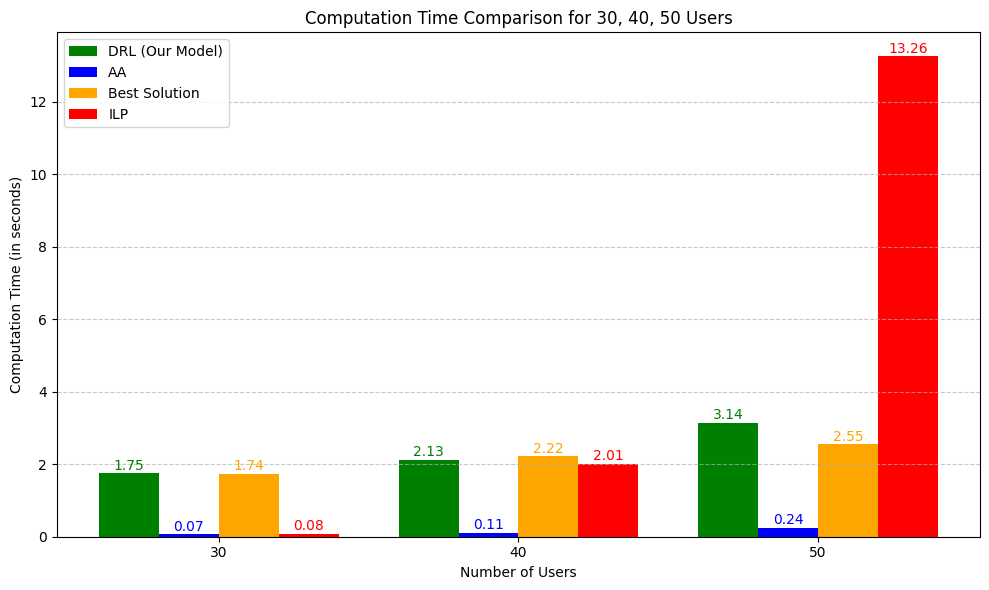

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# User counts
user_counts = [30, 40, 50]

# Computation times (in seconds)
drl_times = [1.75, 2.13, 3.14]
aa_times = [0.0688, 0.1095, 0.24]
best_times = [1.736, 2.217, 2.554]
ilp_times = [0.0807, 2.0083, 13.2567]

# Bar settings
bar_width = 0.2
x = np.arange(len(user_counts))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*bar_width, drl_times, width=bar_width, label='DRL (Our Model)', color='green')
plt.bar(x - 0.5*bar_width, aa_times, width=bar_width, label='AA', color='blue')
plt.bar(x + 0.5*bar_width, best_times, width=bar_width, label='Best Solution', color='orange')
plt.bar(x + 1.5*bar_width, ilp_times, width=bar_width, label='ILP', color='red')

# Annotations
for i in range(len(user_counts)):
    plt.text(x[i] - 1.5*bar_width, drl_times[i] + 0.1, f"{drl_times[i]:.2f}", ha='center', color='green')
    plt.text(x[i] - 0.5*bar_width, aa_times[i] + 0.1, f"{aa_times[i]:.2f}", ha='center', color='blue')
    plt.text(x[i] + 0.5*bar_width, best_times[i] + 0.1, f"{best_times[i]:.2f}", ha='center', color='orange')
    plt.text(x[i] + 1.5*bar_width, ilp_times[i] + 0.1, f"{ilp_times[i]:.2f}", ha='center', color='red')

# Final touches
plt.xticks(x, user_counts)
plt.xlabel("Number of Users")
plt.ylabel("Computation Time (in seconds)")
plt.title("Computation Time Comparison for 30, 40, 50 Users")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


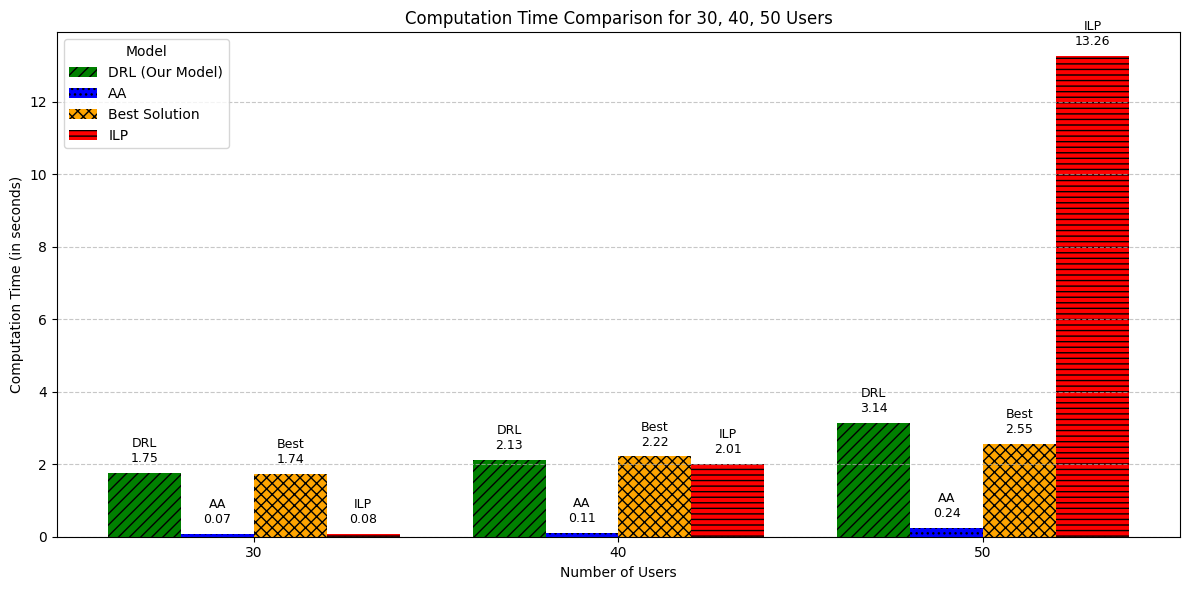

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# User counts
user_counts = [30, 40, 50]

# Computation times (in seconds)
drl_times = [1.75, 2.13, 3.14]
aa_times = [0.0688, 0.1095, 0.24]
best_times = [1.736, 2.217, 2.554]
ilp_times = [0.0807, 2.0083, 13.2567]

# Bar settings
bar_width = 0.2
x = np.arange(len(user_counts))

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*bar_width, drl_times, width=bar_width, label='DRL (Our Model)', color='green', hatch='///')
plt.bar(x - 0.5*bar_width, aa_times, width=bar_width, label='AA', color='blue', hatch='...')
plt.bar(x + 0.5*bar_width, best_times, width=bar_width, label='Best Solution', color='orange', hatch='xxx')
plt.bar(x + 1.5*bar_width, ilp_times, width=bar_width, label='ILP', color='red', hatch='---')

# Annotations (add model names with values)
for i in range(len(user_counts)):
    plt.text(x[i] - 1.5*bar_width, drl_times[i] + 0.3, f"DRL\n{drl_times[i]:.2f}", ha='center', fontsize=9)
    plt.text(x[i] - 0.5*bar_width, aa_times[i] + 0.3, f"AA\n{aa_times[i]:.2f}", ha='center', fontsize=9)
    plt.text(x[i] + 0.5*bar_width, best_times[i] + 0.3, f"Best\n{best_times[i]:.2f}", ha='center', fontsize=9)
    plt.text(x[i] + 1.5*bar_width, ilp_times[i] + 0.3, f"ILP\n{ilp_times[i]:.2f}", ha='center', fontsize=9)

# Final touches
plt.xticks(x, user_counts)
plt.xlabel("Number of Users")
plt.ylabel("Computation Time (in seconds)")
plt.title("Computation Time Comparison for 30, 40, 50 Users")
plt.legend(title="Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
